## Imports

In [1]:
from google.colab import drive
import zipfile
import os

import torch
import random
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torchvision.models import googlenet
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

In [2]:
# Use drive.mount with force_remount=True
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path to your ZIP file in Google Drive
zip_path = '/content/drive/MyDrive/ML Project 2 :)/data (2).zip'

# Extract to a working directory
extract_path = '/content/dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

## Utility functions

### Data augmentation

In [4]:
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, clean_percentage=0.0, cracked_percentage=0.0,
                 clean_lighting_percentage=0.0, cracked_lighting_percentage=0.0,
                 seed=None, device='cpu'):
        """
        Custom dataset to apply random transformations selectively and augment dataset size.

        Args:
            dataset: Original dataset (e.g., datasets.ImageFolder).
            clean_percentage (float): Percentage of 'clean' (label 0) to apply transformations.
            cracked_percentage (float): Percentage of 'cracked' (label 1) to apply transformations.
            clean_lighting_percentage (float): Percentage of 'clean' (label 0) to apply random lighting shifts.
            cracked_lighting_percentage (float): Percentage of 'cracked' (label 1) to apply random lighting shifts.
            seed (int, optional): Random seed for reproducibility.
            device (str): Device to use ('cpu' or 'cuda').
        """
        self.dataset = dataset
        self.clean_percentage = clean_percentage
        self.cracked_percentage = cracked_percentage
        self.clean_lighting_percentage = clean_lighting_percentage
        self.cracked_lighting_percentage = cracked_lighting_percentage
        self.device = device

        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        # Separate indices by labels
        self.clean_indices = [i for i, (_, label) in enumerate(dataset) if label == 0]
        self.cracked_indices = [i for i, (_, label) in enumerate(dataset) if label == 1]

        # Precompute augmented data indices
        self.rotation_indices = set(
            random.sample(self.clean_indices, int(len(self.clean_indices) * clean_percentage)) +
            random.sample(self.cracked_indices, int(len(self.cracked_indices) * cracked_percentage))
        )
        self.lighting_indices = set(
            random.sample(self.clean_indices, int(len(self.clean_indices) * clean_lighting_percentage)) +
            random.sample(self.cracked_indices, int(len(self.cracked_indices) * cracked_lighting_percentage))
        )

        self.rotation_transforms = self.get_rotation_transforms()

    def get_rotation_transforms(self):
        """
        Predefine transformations for random rotations and flips.
        """
        return [
            lambda x: x.transpose(-1, -2),   # 90 degrees rotation
            lambda x: torch.flip(x, dims=(-1, -2)),  # 180 degrees rotation
            lambda x: torch.rot90(x, k=3, dims=(-1, -2)),  # 270 degrees rotation
            lambda x: torch.flip(x, dims=(-1,)),  # Horizontal (N-S) flip
            lambda x: torch.flip(x, dims=(-2,))   # Vertical (E-W) flip
        ]

    def __len__(self):
        return len(self.dataset) + len(self.rotation_indices) + len(self.lighting_indices)

    def __getitem__(self, idx):
        if idx < len(self.dataset):
            # For original dataset items, just return the image and label
            img, label = self.dataset[idx]
            return img.to(self.device), label

        # Handle augmented data (rotations and flips)
        idx -= len(self.dataset)
        if idx < len(self.rotation_indices):
            aug_idx = list(self.rotation_indices)[idx]
            img, label = self.dataset[aug_idx]
            return self.apply_random_transformation(img.to(self.device)), label

        # Handle lighting shift augmentation
        idx -= len(self.rotation_indices)
        aug_idx = list(self.lighting_indices)[idx]
        img, label = self.dataset[aug_idx]
        return self.apply_lighting_shift(img.to(self.device)), label

    def apply_random_transformation(self, img_tensor):
        """
        Apply a random transformation (rotation or flip).
        """
        transform = random.choice(self.rotation_transforms)
        return transform(img_tensor)

    def apply_lighting_shift(self, img_tensor):
        """
        Apply a random lighting shift to the tensor image.
        """
        brightness_factor = torch.FloatTensor(1).uniform_(0.8, 1.2).item()
        return img_tensor * brightness_factor

### ROC curves and AUC

In [5]:
from sklearn.metrics import roc_curve, auc

def plot_average_roc(models, val_loader, device, labels):
    """
    Plots the ROC curve for multiple models and their average.

    Args:
        models (list of torch.nn.Module): List of trained models.
        val_loader (DataLoader): DataLoader for the validation set.
        device (torch.device): Device to use (CPU or GPU).
        labels (list of str): Names of the models for legend labeling.
    """
    all_fpr = np.linspace(0, 1, 100)  # Common FPR axis for interpolation
    tpr_list = []  # Store TPR values for each model's interpolated curve
    auc_list = []  # Store AUC values for each model

    plt.figure(figsize=(10, 8))

    for i, model in enumerate(models):
        model.eval()
        true_labels = []
        pred_probs = []

        # Disable gradient computation during evaluation
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                probabilities = outputs[:, 1]  # Use logits for positive class

                # Append true labels and predicted probabilities
                true_labels.extend(labels.cpu().numpy())
                pred_probs.extend(probabilities.cpu().numpy())

        # Calculate ROC curve metrics
        fpr, tpr, _ = roc_curve(true_labels, pred_probs)
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)

        # Interpolate TPR to common FPR axis
        interpolated_tpr = np.interp(all_fpr, fpr, tpr)
        tpr_list.append(interpolated_tpr)

        # Plot individual model's ROC curve in light grey
        plt.plot(fpr, tpr, color='lightgrey', lw=1, label=f"{labels[i]} (AUC = {roc_auc:.2f})")

    # Compute the average TPR
    mean_tpr = np.mean(tpr_list, axis=0)
    mean_auc = auc(all_fpr, mean_tpr)

    # Plot the average ROC curve in blue
    plt.plot(all_fpr, mean_tpr, color='blue', lw=2, label=f"Average (AUC = {mean_auc:.2f})")

    # Add baseline
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Classifier (AUC = 0.5)")

    # Add labels, title, and legend
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Average ROC Curve Across Models")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

## Training

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 for ResNet
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats to use pretrained weights
])

# Load the datasets again using the final transformation
train_dataset = datasets.ImageFolder(os.path.join(extract_path, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(extract_path, 'validation'), transform=transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Apply the best augmentation found :

In [ ]:
print(len(train_dataset))

clean_rotation_percentage=0.5
cracked_rotation_percentage=0.5
clean_lighting_percentage=0.0
cracked_lighting_percentage=0.0
seed=42

augmented_dataset1 = AugmentedDataset(
        train_dataset, clean_rotation_percentage, cracked_rotation_percentage, clean_lighting_percentage, cracked_lighting_percentage, seed, device)

print(len(augmented_dataset1)) #Not actual size: the class ads indices, and when those are accessed during training an augment is applied acc to if
                               #they belong to rotation indices or lighting ones

train_loader = DataLoader(augmented_dataset1, batch_size=32, shuffle=True)

52193
78289


Start with a learning rate of 1e-3, as found previously to be more effective than 1e-4 for our dataset. This value is used throughout litterature to fine-tune pretrained models :

In [8]:
def create_googlenet():
    model = googlenet(weights="IMAGENET1K_V1")
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model

# Define optimizer function
def optimizer_fn(params):
    return torch.optim.Adam(params, lr=1e-3)

criterion = nn.CrossEntropyLoss()

device='cuda' if torch.cuda.is_available() else 'cpu'

### Cosine annealing

In [ ]:
def train_and_plot_cosineAnnealingLR(train_loader, val_loader, model_fn, criterion, optimizer_fn, device, num_epochs, n_trials, patience, save_dir):
    """
    Trains a model n times with a Cosine Annealing LR scheduler, saves the model after each trial,
    and plots the training and validation loss per epoch. Implements early stopping.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model_fn (function): A callable that returns a new model instance initialized with pre-trained weights.
        criterion (torch.nn.Module): Loss function.
        optimizer_fn (function): Function to create a new optimizer instance for each trial.
        device (torch.device): Device to use (CPU or GPU).
        num_epochs (int): Number of epochs per training.
        n_trials (int): Number of training repetitions.
        save_dir (str): Directory where the model for each trial will be saved.
        patience (int): Number of epochs to wait for validation loss improvement before stopping early.
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    sample_model = model_fn()
    model_name = type(sample_model).__name__

    plt.figure(figsize=(10, 6))

    # To store all losses for averaging
    all_train_losses = []
    all_val_losses = []

    for trial in range(n_trials):
        # Reinitialize the model with ImageNet weights
        model = model_fn().to(device)

        # Create a new optimizer instance for this trial
        optimizer = optimizer_fn(model.parameters())

        # Set up Cosine Annealing LR scheduler with minimum LR of 1e-6
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

        train_losses = []
        val_losses = []

        best_val_loss = float('inf')  # Initialize to a large value
        patience_counter = 0  # Counter to track early stopping patience

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            train_loss = running_loss / len(train_loader)
            train_losses.append(train_loss)

            # Validation phase
            model.eval()
            val_running_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item()
            val_loss = val_running_loss / len(val_loader)
            val_losses.append(val_loss)

            # Print loss for the current epoch
            print(f"Trial {trial + 1}, Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0  # Reset patience counter
                # Optionally save the best model for this trial
                trial_best_model_path = os.path.join(save_dir, f"{model_name}_trial_{trial + 1}_best.pth")
                torch.save(model.state_dict(), trial_best_model_path)
                print(f"New best model for Trial {trial + 1} saved to {trial_best_model_path}")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered for Trial {trial + 1} at Epoch {epoch + 1}")
                    break


        # Save the final model for the trial
        trial_model_path = os.path.join(save_dir, f"{model_name}_trial_{trial + 1}.pth")
        torch.save(model.state_dict(), trial_model_path)
        print(f"Final model for Trial {trial + 1} saved to {trial_model_path}")

        # Store losses for averaging
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        # Plot training and validation losses for this trial
        plt.plot(range(1, len(train_losses) + 1), train_losses, color='blue', alpha=0.3, label='Training Loss' if trial == 0 else "")
        plt.plot(range(1, len(val_losses) + 1), val_losses, color='orange', alpha=0.3, label='Validation Loss' if trial == 0 else "")

    # Calculate average losses per epoch
    avg_train_losses = [sum(epoch_losses) / n_trials for epoch_losses in zip(*all_train_losses)]
    avg_val_losses = [sum(epoch_losses) / n_trials for epoch_losses in zip(*all_val_losses)]

    # Plot average lines
    plt.plot(range(1, len(avg_train_losses) + 1), avg_train_losses, color='blue', linewidth=2, label='Avg Training Loss')
    plt.plot(range(1, len(avg_val_losses) + 1), avg_val_losses, color='orange', linewidth=2, label='Avg Validation Loss')

    # Finalize plot
    plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis shows integer epochs
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Across Trials")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

#### With initial lr=1e-3

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 159MB/s]


Trial 1, Epoch 1, Train Loss: 0.1985, Val Loss: 0.2249
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/cosine/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.1558, Val Loss: 0.1766
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/cosine/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 3, Train Loss: 0.1349, Val Loss: 0.1888
Trial 1, Epoch 4, Train Loss: 0.1192, Val Loss: 0.2424
Trial 1, Epoch 5, Train Loss: 0.1069, Val Loss: 0.2231
Trial 1, Epoch 6, Train Loss: 0.0951, Val Loss: 0.2242
Early stopping triggered for Trial 1 at Epoch 6
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/cosine/GoogLeNet_trial_1.pth
Trial 2, Epoch 1, Train Loss: 0.2033, Val Loss: 0.2929
New best model for Trial 2 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hy

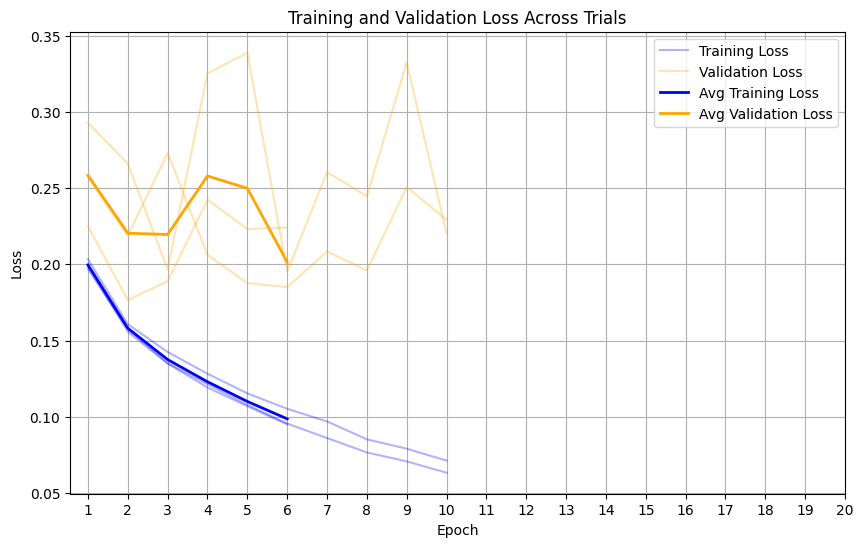

In [ ]:
# Train and plot
train_and_plot_cosineAnnealingLR(train_loader, val_loader, create_googlenet, criterion, optimizer_fn,
               device, num_epochs=20, n_trials=3, patience=4, save_dir='/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/cosine')

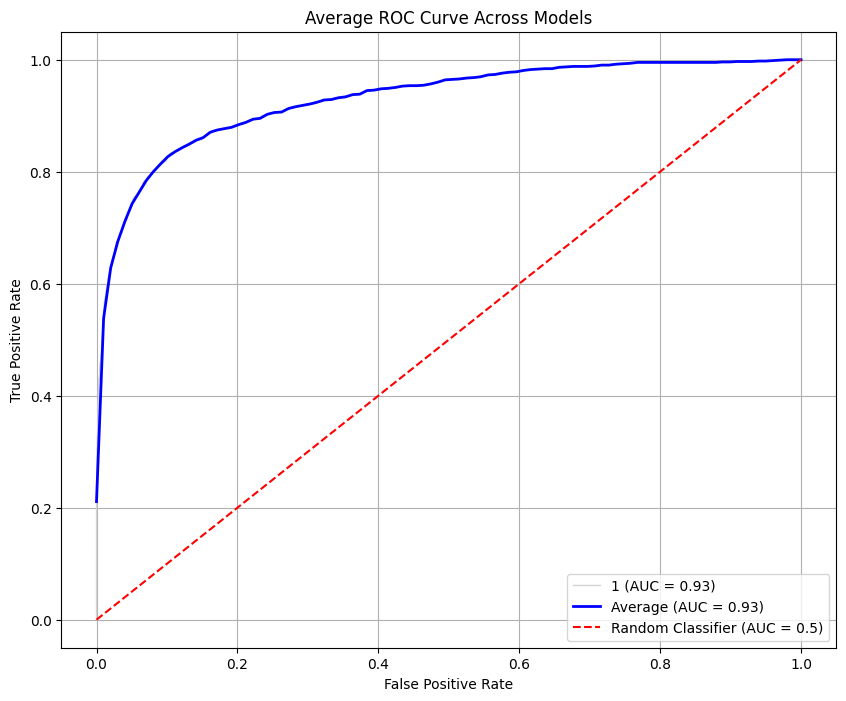

In [11]:
googlenet1 = models.googlenet(weights="IMAGENET1K_V1")
googlenet1.fc = nn.Linear(googlenet1.fc.in_features, 2)
googlenet1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/cosine/GoogLeNet_trial_1_best.pth', weights_only=True))
googlenet1.to(device)

plot_average_roc([googlenet1], val_loader, device, ["cosineAnnealing"])

#### With initial lr=1e-5

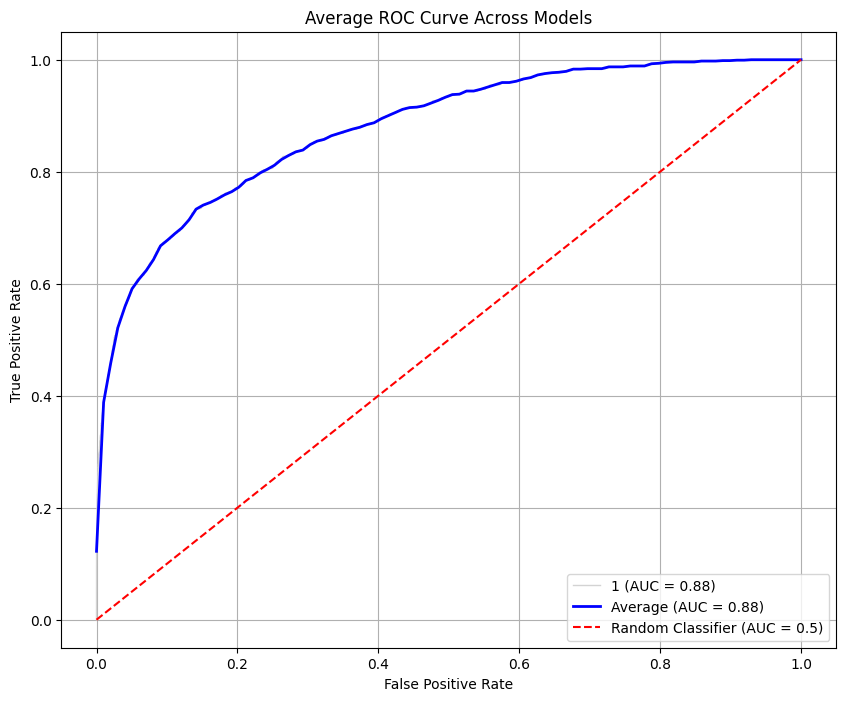

In [15]:
googlenet1 = models.googlenet(weights="IMAGENET1K_V1")
googlenet1.fc = nn.Linear(googlenet1.fc.in_features, 2)
googlenet1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Amélie/cosine/GoogLeNet_trial_1_best (4).pth', weights_only=True))
googlenet1.to(device)

plot_average_roc([googlenet1], val_loader, device, ["cosineAnnealing"])

### Constant learning rate

In [ ]:
def train_and_plot_constantLR(train_loader, val_loader, model_fn, criterion, optimizer_fn, device, num_epochs, n_trials, patience, save_dir):
    """
    Trains a model n times, saves the model after each trial, and plots the training and validation loss per epoch.
    Implements early stopping.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model_fn (function): A callable that returns a new model instance initialized with pre-trained weights.
        criterion (torch.nn.Module): Loss function.
        optimizer_fn (function): Function to create a new optimizer instance for each trial.
        device (torch.device): Device to use (CPU or GPU).
        num_epochs (int): Number of epochs per training.
        n_trials (int): Number of training repetitions.
        save_dir (str): Directory where the model for each trial will be saved.
        patience (int): Number of epochs to wait for validation loss improvement before stopping early.
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    sample_model = model_fn()
    model_name = type(sample_model).__name__

    plt.figure(figsize=(10, 6))

    # To store all losses for averaging
    all_train_losses = []
    all_val_losses = []

    for trial in range(n_trials):
        # Reinitialize the model with ImageNet weights
        model = model_fn().to(device)

        # Create a new optimizer instance for this trial
        optimizer = optimizer_fn(model.parameters())

        train_losses = []
        val_losses = []

        best_val_loss = float('inf')  # Initialize to a large value
        patience_counter = 0  # Counter to track early stopping patience

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            train_loss = running_loss / len(train_loader)
            train_losses.append(train_loss)

            # Validation phase
            model.eval()
            val_running_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item()
            val_loss = val_running_loss / len(val_loader)
            val_losses.append(val_loss)

            # Print loss for the current epoch
            print(f"Trial {trial + 1}, Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0  # Reset patience counter
                # Optionally save the best model for this trial
                trial_best_model_path = os.path.join(save_dir, f"{model_name}_trial_{trial + 1}_best.pth")
                torch.save(model.state_dict(), trial_best_model_path)
                print(f"New best model for Trial {trial + 1} saved to {trial_best_model_path}")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered for Trial {trial + 1} at Epoch {epoch + 1}")
                    break


        # Save the final model for the trial
        trial_model_path = os.path.join(save_dir, f"{model_name}_trial_{trial + 1}.pth")
        torch.save(model.state_dict(), trial_model_path)
        print(f"Final model for Trial {trial + 1} saved to {trial_model_path}")

        # Store losses for averaging
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        # Plot training and validation losses for this trial
        plt.plot(range(1, len(train_losses) + 1), train_losses, color='blue', alpha=0.3, label='Training Loss' if trial == 0 else "")
        plt.plot(range(1, len(val_losses) + 1), val_losses, color='orange', alpha=0.3, label='Validation Loss' if trial == 0 else "")

    # Calculate average losses per epoch
    avg_train_losses = [sum(epoch_losses) / n_trials for epoch_losses in zip(*all_train_losses)]
    avg_val_losses = [sum(epoch_losses) / n_trials for epoch_losses in zip(*all_val_losses)]

    # Plot average lines
    plt.plot(range(1, len(avg_train_losses) + 1), avg_train_losses, color='blue', linewidth=2, label='Avg Training Loss')
    plt.plot(range(1, len(avg_val_losses) + 1), avg_val_losses, color='orange', linewidth=2, label='Avg Validation Loss')

    # Finalize plot
    plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis shows integer epochs
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Across Trials")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

#### With initial lr=1e-5

In [ ]:
def create_googlenet():
    model = googlenet(weights="IMAGENET1K_V1")
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model

# Define optimizer function
def optimizer_fn(params):
    return torch.optim.Adam(params, lr=1e-5)

criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 175MB/s]


Trial 1, Epoch 1, Train Loss: 0.2155, Val Loss: 0.2464
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/constantLR/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.1438, Val Loss: 0.2574
Trial 1, Epoch 3, Train Loss: 0.1185, Val Loss: 0.2466
Trial 1, Epoch 4, Train Loss: 0.1000, Val Loss: 0.2379
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/constantLR/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 5, Train Loss: 0.0849, Val Loss: 0.2909
Trial 1, Epoch 6, Train Loss: 0.0717, Val Loss: 0.2507
Trial 1, Epoch 7, Train Loss: 0.0633, Val Loss: 0.2411
Trial 1, Epoch 8, Train Loss: 0.0556, Val Loss: 0.2504
Trial 1, Epoch 9, Train Loss: 0.0489, Val Loss: 0.2657
Trial 1, Epoch 10, Train Loss: 0.0437, Val Loss: 0.2806
Trial 1, Epoch 11, Train Loss: 0.0394, Val Loss: 0.2877
Trial 1, Epoch 12, Train Loss: 0.0356, Val Loss: 0.3185
Trial 1, Ep

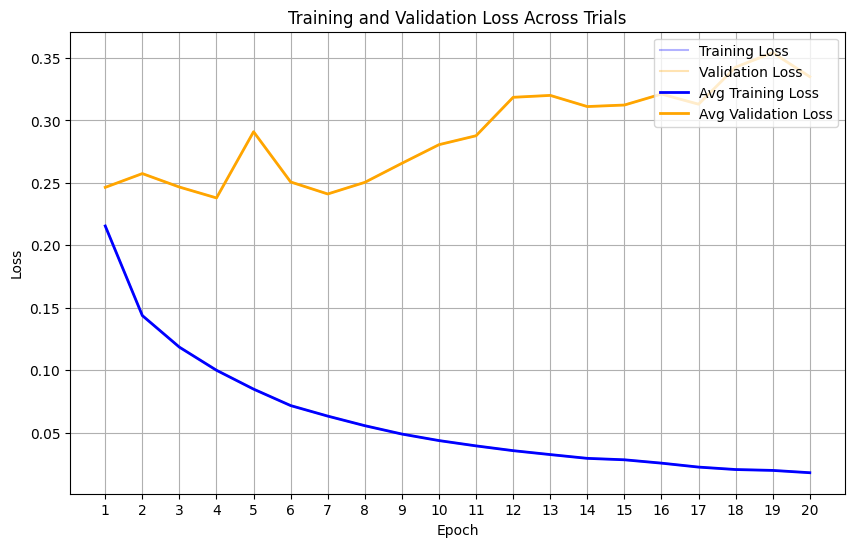

In [ ]:
# Train and plot
train_and_plot_constantLR(train_loader, val_loader, create_googlenet, criterion, optimizer_fn,
               device, num_epochs=20, n_trials=1, patience=20, save_dir='/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/constantLR')

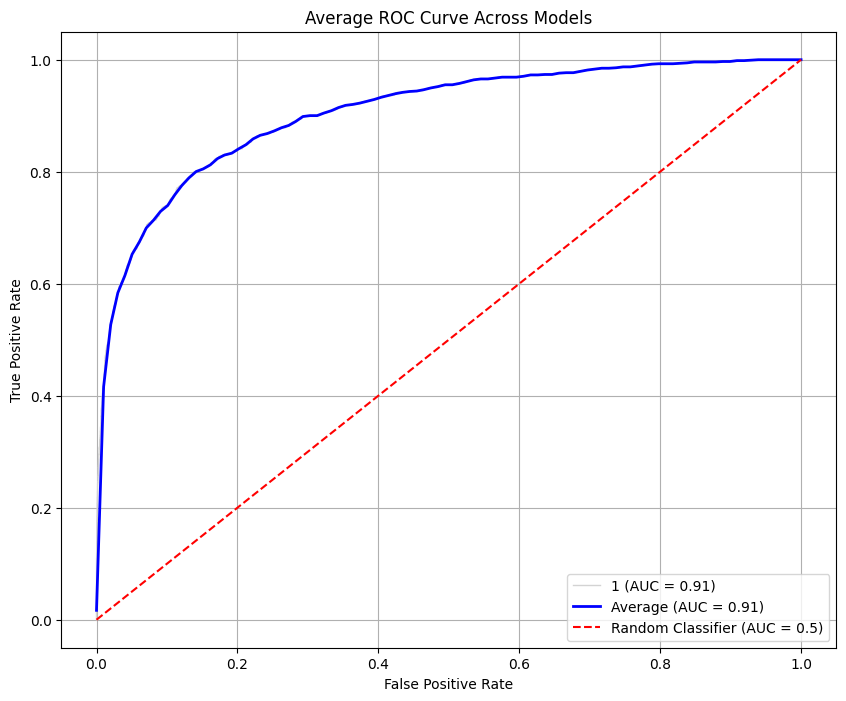

In [12]:
googlenet1 = models.googlenet(weights="IMAGENET1K_V1")
googlenet1.fc = nn.Linear(googlenet1.fc.in_features, 2)
googlenet1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/constantLR/GoogLeNet_trial_1_best.pth', weights_only=True))
googlenet1.to(device)

plot_average_roc([googlenet1], val_loader, device, ["constant"])

### Reduce LR on plateau

In [ ]:
def train_and_plot_reduceLRplateau(train_loader, val_loader, model_fn, criterion, optimizer_fn, device, num_epochs, n_trials, patience, save_dir):
    """
    Trains a model n times with a ReduceLROnPlateau scheduler, saves the model after each trial,
    and plots the training and validation loss per epoch. Implements early stopping.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model_fn (function): A callable that returns a new model instance initialized with pre-trained weights.
        criterion (torch.nn.Module): Loss function.
        optimizer_fn (function): Function to create a new optimizer instance for each trial.
        device (torch.device): Device to use (CPU or GPU).
        num_epochs (int): Number of epochs per training.
        n_trials (int): Number of training repetitions.
        patience (int): Number of epochs to wait for validation loss improvement before stopping early.
        save_dir (str): Directory where the model for each trial will be saved.
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    sample_model = model_fn()
    model_name = type(sample_model).__name__

    plt.figure(figsize=(10, 6))

    # To store all losses for averaging
    all_train_losses = []
    all_val_losses = []

    for trial in range(n_trials):
        # Reinitialize the model with ImageNet weights
        model = model_fn().to(device)

        # Create a new optimizer instance for this trial
        optimizer = optimizer_fn(model.parameters())

        # Set up ReduceLROnPlateau scheduler
        lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True, min_lr=1e-6)

        train_losses = []
        val_losses = []

        best_val_loss = float('inf')  # Initialize to a large value
        patience_counter = 0  # Counter to track early stopping patience

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            train_loss = running_loss / len(train_loader)
            train_losses.append(train_loss)

            # Validation phase
            model.eval()
            val_running_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item()
            val_loss = val_running_loss / len(val_loader)
            val_losses.append(val_loss)

            # Update the scheduler
            lr_scheduler.step(val_loss)

            # Print loss and current learning rate for the epoch
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Trial {trial + 1}, Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0  # Reset patience counter
                # Optionally save the best model for this trial
                trial_best_model_path = os.path.join(save_dir, f"{model_name}_trial_{trial + 1}_best.pth")
                torch.save(model.state_dict(), trial_best_model_path)
                print(f"New best model for Trial {trial + 1} saved to {trial_best_model_path}")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered for Trial {trial + 1} at Epoch {epoch + 1}")
                    break

        # Save the final model for the trial
        trial_model_path = os.path.join(save_dir, f"{model_name}_trial_{trial + 1}.pth")
        torch.save(model.state_dict(), trial_model_path)
        print(f"Final model for Trial {trial + 1} saved to {trial_model_path}")

        # Store losses for averaging
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        # Plot training and validation losses for this trial
        plt.plot(range(1, len(train_losses) + 1), train_losses, color='blue', alpha=0.3, label='Training Loss' if trial == 0 else "")
        plt.plot(range(1, len(val_losses) + 1), val_losses, color='orange', alpha=0.3, label='Validation Loss' if trial == 0 else "")

    # Calculate average losses per epoch
    avg_train_losses = [sum(epoch_losses) / n_trials for epoch_losses in zip(*all_train_losses)]
    avg_val_losses = [sum(epoch_losses) / n_trials for epoch_losses in zip(*all_val_losses)]

    # Plot average lines
    plt.plot(range(1, len(avg_train_losses) + 1), avg_train_losses, color='blue', linewidth=2, label='Avg Training Loss')
    plt.plot(range(1, len(avg_val_losses) + 1), avg_val_losses, color='orange', linewidth=2, label='Avg Validation Loss')

    # Finalize plot
    plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis shows integer epochs
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Across Trials (ReduceLROnPlateau)")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

#### With initial lr=1e-3

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 121MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Trial 1, Epoch 1, Train Loss: 0.2074, Val Loss: 0.2890, LR: 0.001000
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/plateau/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.1634, Val Loss: 0.2039, LR: 0.001000
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/plateau/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 3, Train Loss: 0.1423, Val Loss: 0.2400, LR: 0.001000
Trial 1, Epoch 4, Train Loss: 0.1268, Val Loss: 0.3488, LR: 0.001000
Trial 1, Epoch 5, Train Loss: 0.1153, Val Loss: 0.2262, LR: 0.001000
Trial 1, Epoch 6, Train Loss: 0.1057, Val Loss: 0.2291, LR: 0.001000
Trial 1, Epoch 7, Train Loss: 0.0970, Val Loss: 0.3125, LR: 0.001000
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/plateau/GoogLeNet_trial_1.pth


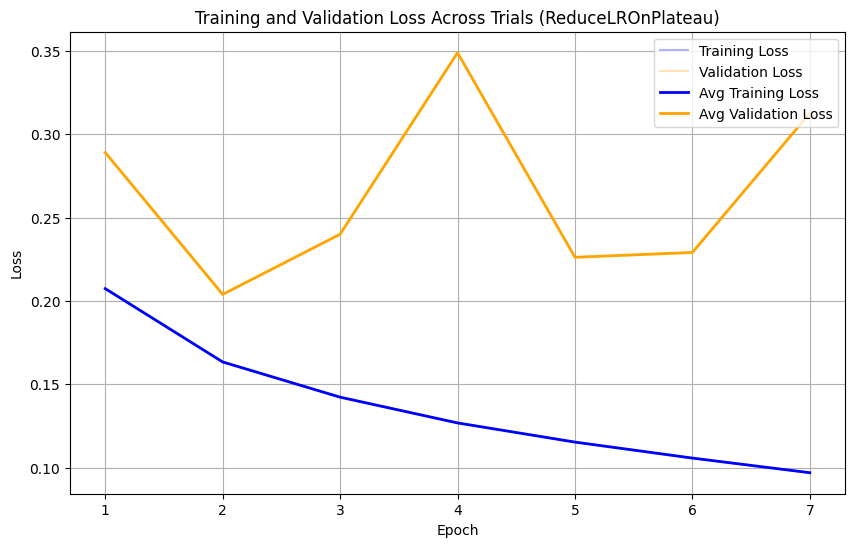

In [ ]:
# Train and plot
train_and_plot_reduceLRplateau(train_loader, val_loader, create_googlenet, criterion, optimizer_fn,
               device, num_epochs=7, n_trials=1, patience=20, save_dir='/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/plateau')

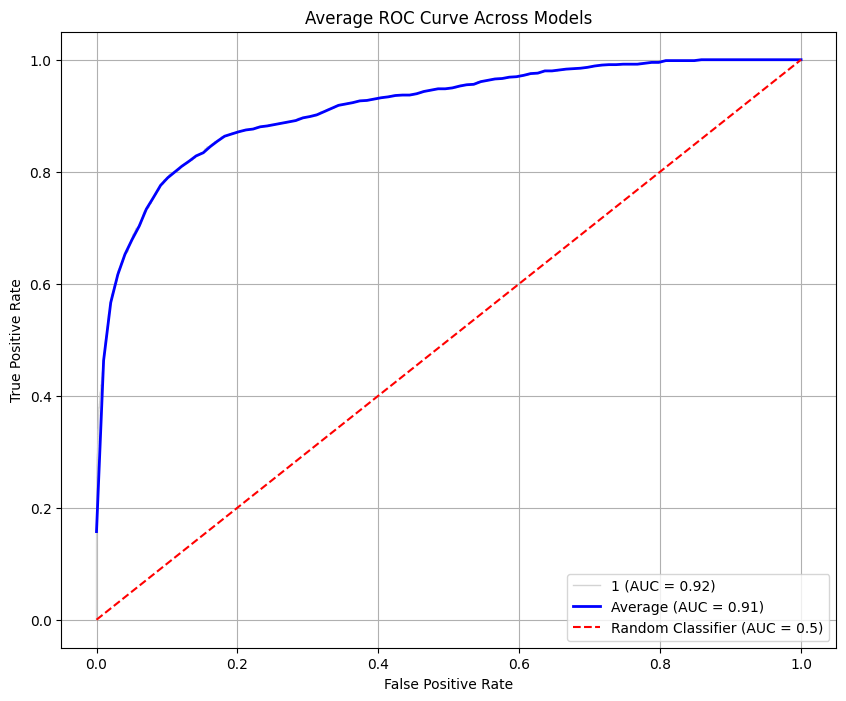

In [16]:
googlenet1 = models.googlenet(weights="IMAGENET1K_V1")
googlenet1.fc = nn.Linear(googlenet1.fc.in_features, 2)
googlenet1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/plateau/GoogLeNet_trial_1_best.pth', weights_only=True))
googlenet1.to(device)

plot_average_roc([googlenet1], val_loader, device, ["plateau"])

#### With initial lr=1e-4

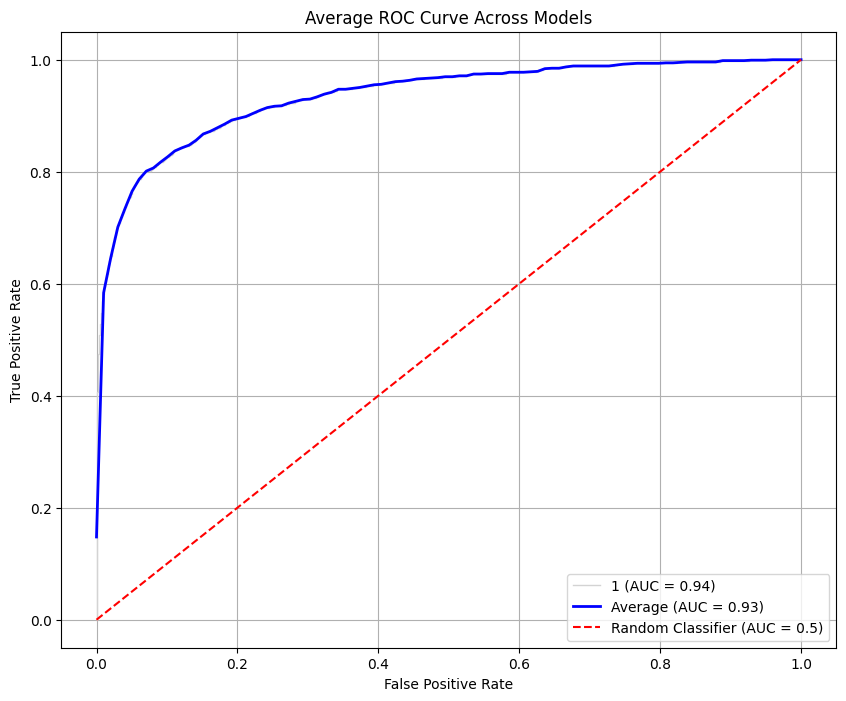

In [14]:
googlenet1 = models.googlenet(weights="IMAGENET1K_V1")
googlenet1.fc = nn.Linear(googlenet1.fc.in_features, 2)
googlenet1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Amélie/plateau/GoogLeNet_trial_1_best.pth', weights_only=True))
googlenet1.to(device)

plot_average_roc([googlenet1], val_loader, device, ["plateau"])

## Reducing batch size

It could help against overfitting.
Cosine annealing, batch_size=16, fewer epochs.

In [ ]:
print(len(train_dataset))

clean_rotation_percentage=0.5
cracked_rotation_percentage=0.5
clean_lighting_percentage=0.0
cracked_lighting_percentage=0.0
seed=42
device='cuda' if torch.cuda.is_available() else 'cpu'

augmented_dataset1 = AugmentedDataset(
        train_dataset, clean_rotation_percentage, cracked_rotation_percentage, clean_lighting_percentage, cracked_lighting_percentage, seed, device)

print(len(augmented_dataset1)) #Not actual size: the class ads indices, and when those are accessed during training an augment is applied acc to if
                               #they belong to rotation indices or lighting ones

train_loader = DataLoader(augmented_dataset1, batch_size=16, shuffle=True)

52193
78289


In [ ]:
def create_googlenet():
    model = googlenet(weights="IMAGENET1K_V1")
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model

# Define optimizer function
def optimizer_fn(params):
    return torch.optim.Adam(params, lr=1e-3)

criterion = nn.CrossEntropyLoss()

Trial 1, Epoch 1, Train Loss: 0.2195, Val Loss: 0.4525
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/cosine16/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.1716, Val Loss: 0.2130
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/cosine16/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 3, Train Loss: 0.1525, Val Loss: 0.1946
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/cosine16/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 4, Train Loss: 0.1381, Val Loss: 0.2556
Trial 1, Epoch 5, Train Loss: 0.1274, Val Loss: 0.2344
Trial 1, Epoch 6, Train Loss: 0.1199, Val Loss: 0.2027
Trial 1, Epoch 7, Train Loss: 0.1118, Val Loss: 0.2319
Trial 1, Epoch 8, Train Loss: 0.1061, Val Loss: 0.1891
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Mo

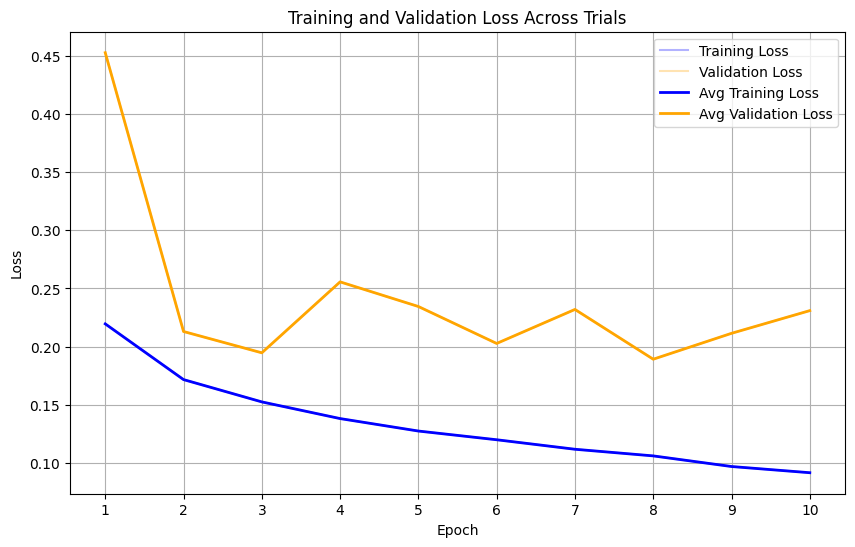

In [ ]:
# Train and plot
train_and_plot_cosineAnnealingLR(train_loader, val_loader, create_googlenet, criterion, optimizer_fn,
               device, num_epochs=10, n_trials=1, patience=10, save_dir='/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/cosine16')

This is better, as the optimal validation loss still updates after more than 4 epochs. We can try this method for a higher number of iterations:

Trial 1, Epoch 1, Train Loss: 0.2284, Val Loss: 0.2218
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/cosine16_bis/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.1783, Val Loss: 0.1990
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/cosine16_bis/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 3, Train Loss: 0.1523, Val Loss: 0.2703
Trial 1, Epoch 4, Train Loss: 0.1405, Val Loss: 0.2167
Trial 1, Epoch 5, Train Loss: 0.1294, Val Loss: 0.2266
Trial 1, Epoch 6, Train Loss: 0.1219, Val Loss: 0.2017
Trial 1, Epoch 7, Train Loss: 0.1144, Val Loss: 0.2416
Trial 1, Epoch 8, Train Loss: 0.1082, Val Loss: 0.2143
Trial 1, Epoch 9, Train Loss: 0.0999, Val Loss: 0.2786
Trial 1, Epoch 10, Train Loss: 0.0939, Val Loss: 0.2798
Trial 1, Epoch 11, Train Loss: 0.0881, Val Loss: 0.3885
Trial 1, Epoch 12, Train Loss: 0.0826, Val Loss: 0.2423
Trial 1

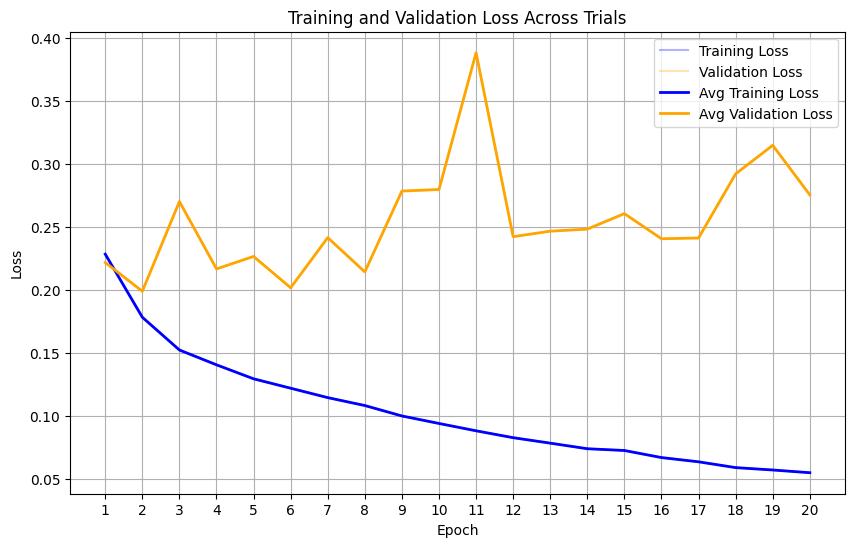

In [ ]:
# Train and plot
train_and_plot_cosineAnnealingLR(train_loader, val_loader, create_googlenet, criterion, optimizer_fn,
               device, num_epochs=20, n_trials=1, patience=20, save_dir='/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/cosine16_bis')

Maybe the worst performance comes from the fact that the learning rate doesn't decrease at the right rate. In all cases, the best performance might not need many epoch (max 4). We wil continue exploring based on the best result yet: the one with batch_size=32 and cosine annealing:

## Extra: try less iterations

In [ ]:
def train_and_plot_cosineAnnealingLR_iterations(train_loader, val_loader, model_fn, criterion, optimizer_fn, device, num_iterations, n_trials, patience, lr_min, save_dir):
    """
    Trains a model n times with a Cosine Annealing LR scheduler, saves the model after each trial,
    and plots the training and validation loss per iteration. Implements early stopping.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model_fn (function): A callable that returns a new model instance initialized with pre-trained weights.
        criterion (torch.nn.Module): Loss function.
        optimizer_fn (function): Function to create a new optimizer instance for each trial.
        device (torch.device): Device to use (CPU or GPU).
        num_iterations (int): Total number of iterations to train.
        n_trials (int): Number of training repetitions.
        save_dir (str): Directory where the model for each trial will be saved.
        patience (int): Number of iterations to wait for validation loss improvement before stopping early.
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    sample_model = model_fn()
    model_name = type(sample_model).__name__

    plt.figure(figsize=(10, 6))

    all_train_losses = []
    all_val_losses = []
    iteration_numbers = []

    for trial in range(n_trials):
        # Reinitialize the model
        model = model_fn().to(device)

        # Create a new optimizer instance for this trial
        optimizer = optimizer_fn(model.parameters())

        # Cosine Annealing LR scheduler with minimum LR of 1e-6
        scheduler = CosineAnnealingLR(optimizer, T_max=num_iterations, eta_min=lr_min)

        # Initialize variables for tracking losses and early stopping
        train_losses = []
        val_losses = []
        trial_iteration_numbers = []

        best_val_loss = float('inf')
        patience_counter = 0
        total_iterations = 0
        stop_training = False

        running_train_loss = 0.0  # Accumulate training loss for averaging

        for epoch in range(9999):  # Infinite epoch loop until iterations are complete
            if stop_training:
                break

            model.train()
            for images, labels in train_loader:
                if total_iterations >= num_iterations:
                    stop_training = True
                    break

                # Training step
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                scheduler.step()

                # Accumulate training loss
                running_train_loss += loss.item()

                # Log every 100 iterations
                if (total_iterations + 1) % 100 == 0:
                    avg_train_loss = running_train_loss / 100  # Average over 100 iterations
                    running_train_loss = 0.0  # Reset the running loss

                    # Validation phase
                    model.eval()
                    val_loss = 0.0
                    with torch.no_grad():
                        for val_images, val_labels in val_loader:
                            val_images, val_labels = val_images.to(device), val_labels.to(device)
                            val_outputs = model(val_images)
                            val_loss += criterion(val_outputs, val_labels).item()
                    val_loss /= len(val_loader)

                    # Store losses and iteration number
                    train_losses.append(avg_train_loss)
                    val_losses.append(val_loss)
                    trial_iteration_numbers.append(total_iterations + 1)

                    # Print current losses
                    print(f"Trial {trial + 1}, Iteration {total_iterations + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

                    # Early stopping check
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        trial_best_model_path = os.path.join(save_dir, f"{model_name}_trial_{trial + 1}_best.pth")
                        torch.save(model.state_dict(), trial_best_model_path)
                        print(f"New best model for Trial {trial + 1} saved to {trial_best_model_path}")
                    else:
                        patience_counter += 1
                        if patience_counter >= patience:
                            print(f"Early stopping triggered for Trial {trial + 1} at Iteration {total_iterations + 1}")
                            stop_training = True
                            break

                total_iterations += 1

        # Save the final model for the trial
        trial_model_path = os.path.join(save_dir, f"{model_name}_trial_{trial + 1}.pth")
        torch.save(model.state_dict(), trial_model_path)
        print(f"Final model for Trial {trial + 1} saved to {trial_model_path}")

        # Store losses for averaging across trials
        if not iteration_numbers:
            iteration_numbers = trial_iteration_numbers
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        # Plot individual trial losses
        plt.plot(trial_iteration_numbers, train_losses, color='blue', alpha=0.3, label='Training Loss' if trial == 0 else "")
        plt.plot(trial_iteration_numbers, val_losses, color='orange', alpha=0.3, label='Validation Loss' if trial == 0 else "")

    # Average losses across trials
    avg_train_losses = [sum(x) / n_trials for x in zip(*all_train_losses)]
    avg_val_losses = [sum(x) / n_trials for x in zip(*all_val_losses)]

    # Plot averaged losses
    plt.plot(iteration_numbers, avg_train_losses, color='blue', linewidth=2, label='Average Training Loss')
    plt.plot(iteration_numbers, avg_val_losses, color='orange', linewidth=2, label='Average Validation Loss')

    # Finalize the plot
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Across Trials")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

atch_size=32 and 4 epoch correspond to 4*78289/32=9786 iterations, so we choose to perform 10'000 iterations. Multiple minimal learning rates are tried :

Trial 1, Iteration 100, Train Loss: 0.3319, Val Loss: 0.4486
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/final/1e-3/GoogLeNet_trial_1_best.pth
Trial 1, Iteration 200, Train Loss: 0.3914, Val Loss: 0.3601
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/final/1e-3/GoogLeNet_trial_1_best.pth
Trial 1, Iteration 300, Train Loss: 0.3602, Val Loss: 0.3828
Trial 1, Iteration 400, Train Loss: 0.3667, Val Loss: 0.3601
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/final/1e-3/GoogLeNet_trial_1_best.pth
Trial 1, Iteration 500, Train Loss: 0.3484, Val Loss: 0.3600
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/final/1e-3/GoogLeNet_trial_1_best.pth
Trial 1, Iteration 600, Train Loss: 0.3584,

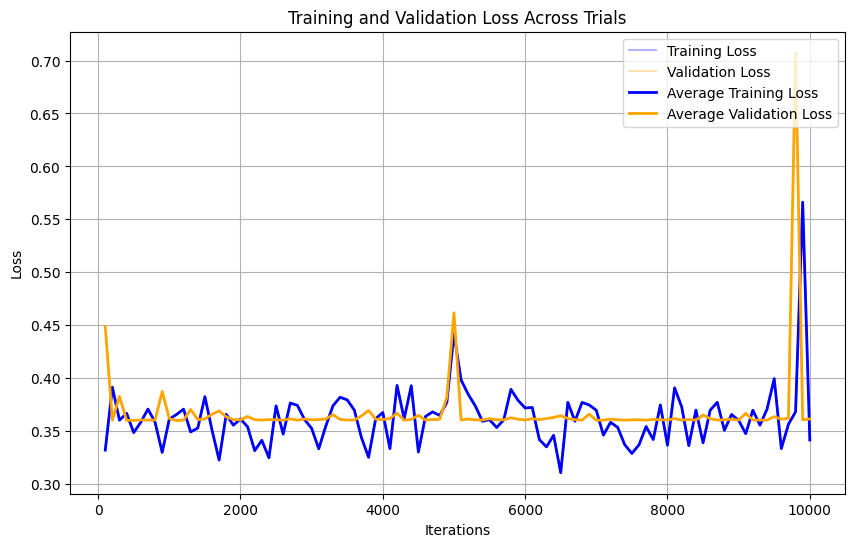

Trial 1, Iteration 100, Train Loss: 0.3065, Val Loss: 0.4866
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/final/1e-4/GoogLeNet_trial_1_best.pth
Trial 1, Iteration 200, Train Loss: 0.3733, Val Loss: 0.3601
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/final/1e-4/GoogLeNet_trial_1_best.pth
Trial 1, Iteration 300, Train Loss: 0.3916, Val Loss: 0.3800
Trial 1, Iteration 400, Train Loss: 0.3235, Val Loss: 0.3811
Trial 1, Iteration 500, Train Loss: 0.3338, Val Loss: 0.3612
Trial 1, Iteration 600, Train Loss: 0.3474, Val Loss: 0.3640
Trial 1, Iteration 700, Train Loss: 0.3671, Val Loss: 0.4420
Trial 1, Iteration 800, Train Loss: 0.3572, Val Loss: 0.3613
Trial 1, Iteration 900, Train Loss: 0.3292, Val Loss: 0.3605
Trial 1, Iteration 1000, Train Loss: 0.3630, Val Loss: 0.3602
Trial 1, Iteration 1100, Train Loss: 0.3822, Val Loss: 0.3605
T

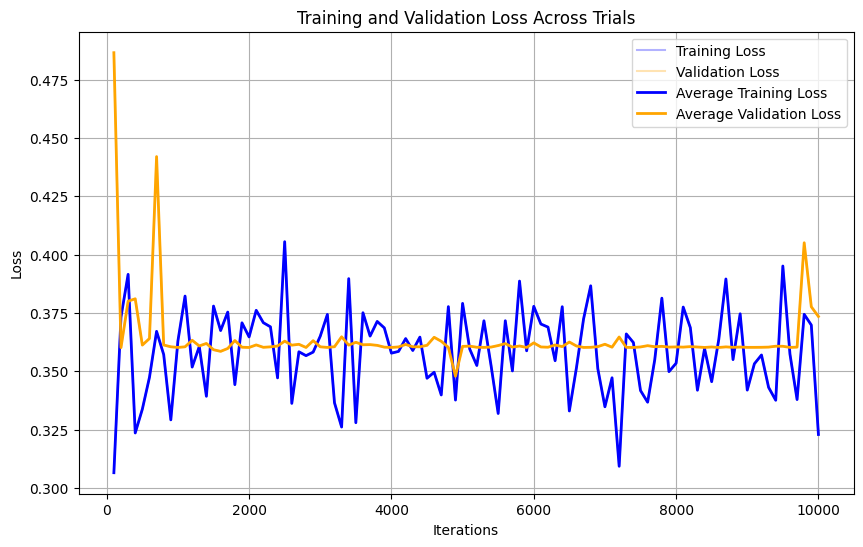

Trial 1, Iteration 100, Train Loss: 0.3056, Val Loss: 1.0789
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/final/1e-5/GoogLeNet_trial_1_best.pth
Trial 1, Iteration 200, Train Loss: 0.3764, Val Loss: 0.3602
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/final/1e-5/GoogLeNet_trial_1_best.pth
Trial 1, Iteration 300, Train Loss: 0.3871, Val Loss: 0.3553
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/final/1e-5/GoogLeNet_trial_1_best.pth
Trial 1, Iteration 400, Train Loss: 0.3453, Val Loss: 0.3612
Trial 1, Iteration 500, Train Loss: 0.3502, Val Loss: 0.3616
Trial 1, Iteration 600, Train Loss: 0.3350, Val Loss: 0.3691
Trial 1, Iteration 700, Train Loss: 0.3543, Val Loss: 0.3608
Trial 1, Iteration 800, Train Loss: 0.3740, Val Loss: 0.3627
Trial 1, Iteration 900,

In [ ]:
train_and_plot_cosineAnnealingLR_iterations(train_loader, val_loader, create_googlenet, criterion, optimizer_fn, device, num_iterations=10000,
                                            n_trials=1, patience=10000, lr_min=1e-3, save_dir='/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/final/1e-3')

train_and_plot_cosineAnnealingLR_iterations(train_loader, val_loader, create_googlenet, criterion, optimizer_fn, device, num_iterations=10000,
                                            n_trials=1, patience=10000, lr_min=1e-4, save_dir='/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/final/1e-4')

train_and_plot_cosineAnnealingLR_iterations(train_loader, val_loader, create_googlenet, criterion, optimizer_fn, device, num_iterations=10000,
                                            n_trials=1, patience=10000, lr_min=1e-5, save_dir='/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/final/1e-5')

Trial 1, Iteration 100, Train Loss: 0.2715, Val Loss: 0.3249
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/cosine/iterations/GoogLeNet_trial_1_best.pth
Trial 1, Iteration 200, Train Loss: 0.3647, Val Loss: 0.3576
Trial 1, Iteration 300, Train Loss: 0.3734, Val Loss: 0.3603
Trial 1, Iteration 400, Train Loss: 0.3780, Val Loss: 0.3640
Trial 1, Iteration 500, Train Loss: 0.3731, Val Loss: 0.3732
Trial 1, Iteration 600, Train Loss: 0.3745, Val Loss: 0.3613
Trial 1, Iteration 700, Train Loss: 0.3566, Val Loss: 0.3600
Trial 1, Iteration 800, Train Loss: 0.3739, Val Loss: 0.4285
Trial 1, Iteration 900, Train Loss: 0.3846, Val Loss: 0.3602
Trial 1, Iteration 1000, Train Loss: 0.3597, Val Loss: 0.3632
Trial 1, Iteration 1100, Train Loss: 0.3367, Val Loss: 0.3590
Trial 1, Iteration 1200, Train Loss: 0.3766, Val Loss: 0.3605
Trial 1, Iteration 1300, Train Loss: 0.3576, Val Loss: 0.3603
Trial 1, Iteration 1400, Train Lo

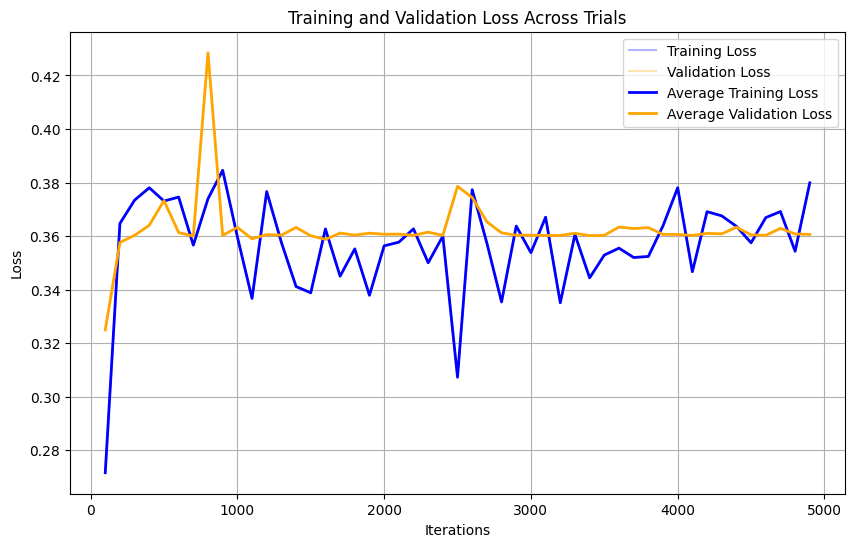

In [ ]:
train_and_plot_cosineAnnealingLR_iterations(train_loader, val_loader, create_googlenet, criterion, optimizer_fn, device, num_iterations=4900,
                                            n_trials=1, patience=4900, lr_min=9.7e-4, save_dir='/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/cosine/iterations')